In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy as sp

import holodeck as holo
import holodeck.single_sources as ss
import holodeck.detstats as det
from holodeck.constants import YR, MSOL
from holodeck import utils


import hasasia.sensitivity as hsen
import hasasia.sim as hsim

# Build SAM and calculate strains

Make the semi-analytic model object.

In [51]:
dur = 10.0*YR
cad = 0.2*YR
fobs = utils.nyquist_freqs(dur,cad)
fobs_edges = utils.nyquist_freqs_edges(dur,cad)
sam = holo.sam.Semi_Analytic_Model(ZERO_GMT_STALLED_SYSTEMS=True, ZERO_DYNAMIC_STALLED_SYSTEMS=False) 
# sam = holo.sam.Semi_Analytic_Model(mtot=(1.0e4*MSOL, 1.0e11*MSOL, 20), mrat=(1e-3, 1.0, 20), redz=(1e-3, 10.0, 20))  # faster version
hard = holo.hardening.Hard_GW

Calculate strains.

In [52]:
fobs_orb_edges = fobs_edges / 2.0 
fobs_orb_cents = fobs/ 2.0
# edges
edges, dnum = sam.dynamic_binary_number(hard, fobs_orb=fobs_orb_cents) # should the zero stalled option be part of the parameter space?
edges[-1] = fobs_orb_edges
# integrate for number
number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
number = number * np.diff(np.log(fobs_edges)) 
hc_ss, hc_bg = ss.ss_gws(edges, number, realize=30, 
                                        loudest = 1, params = False) 


21:19:31 INFO : zero_coalesced=True, zero_stalled=False [sam.py:dynamic_binary_number]
21:19:31 INFO : Stalled SAM bins based on GMT: 1.98e+05/4.99e+05 = 3.96e-01 [sam.py:static_binary_density]
21:19:31 INFO : Adding MMbulge scatter (3.4000e-01) [sam.py:static_binary_density]
21:19:32 INFO : 	dens bef: (1.28e-114, 5.22e-53, 2.59e-13, 2.12e-03, 1.66e-02, 2.92e-02, 4.47e-02) [sam.py:static_binary_density]
21:19:38 INFO : Scatter added after 6.444761 sec [sam.py:static_binary_density]
21:19:38 INFO : 	dens aft: (6.14e-17, 7.92e-09, 2.90e-06, 2.19e-03, 1.69e-02, 2.92e-02, 4.27e-02) [sam.py:static_binary_density]
21:19:38 INFO : 	mass: 8.56e-02 ==> 8.54e-02 || change = -1.8507e-03 [sam.py:static_binary_density]
21:19:38 INFO : zeroing out 1.98e+05/4.99e+05 = 3.96e-01 systems stalled from GMT [sam.py:static_binary_density]
21:19:38 INFO : fraction of coalesced binaries: 4.33e+05/1.25e+07 = 3.47e-02 [sam.py:dynamic_binary_number]
21:19:38 INFO : stalled binaries are not being accounted for in

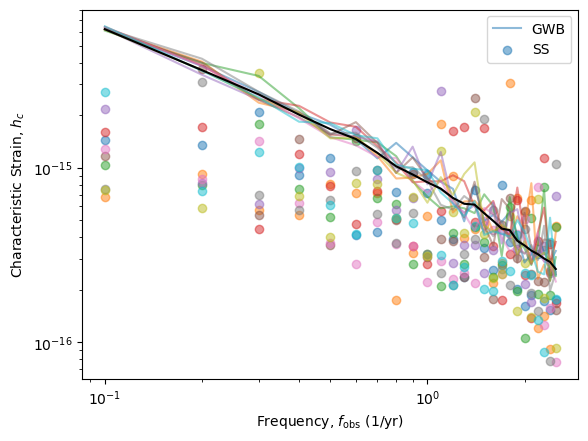

In [53]:
nreals = np.min([10, len(hc_bg[0])])
colors = cm.rainbow(np.linspace(0,1,nreals))
plt.xlabel('Frequency, $f_\mathrm{obs}$ (1/yr)')
plt.ylabel('Characteristic Strain, $h_c$')
for rr in range(nreals):
    if(rr==0):
        label_bg = 'GWB'
        label_ss = 'SS'
    else:
        label_bg = None
        label_ss = None
    plt.loglog(fobs*YR, hc_bg[:,rr], alpha=0.5, label=label_bg)
    plt.scatter(fobs*YR, hc_ss[:,rr,0], alpha=0.5, label=label_ss)
plt.loglog(fobs*YR, np.median(hc_bg, axis=1), color='k')
plt.legend()


# Build pulsar timing array

Place pulsars at random positions with random white noise, and create a list of hasasia.sensitivity.Pulsar objects with hasasia.sim.sim_pta.
A single PTA is created and used to calculate detection statistics on many realizations of GW sources.

In [54]:
npsrs = 40
phis = np.random.uniform(0, 2*np.pi, size=npsrs)
thetas = np.random.uniform(0, np.pi, size=npsrs)
sigmas = np.random.uniform(1e-7, 4e-6, npsrs)

pulsars = hsim.sim_pta(timespan=dur/YR, cad=1/(cad/YR), sigma=sigmas,
                       phi=phis, theta=thetas)
print(pulsars[0].__dict__.keys())

dict_keys(['toas', 'toaerrs', 'phi', 'theta', 'pdist', 'N', 'designmatrix'])


Get a spectrum for each pulsar.

In [55]:
spectra = np.empty_like(pulsars, dtype=hsen.Spectrum)
for ii in range(npsrs):
    spectra[ii] = hsen.Spectrum(pulsars[ii], freqs=fobs)
    spectra[ii].NcalInv # calculate inverse noise weighted transmission function 

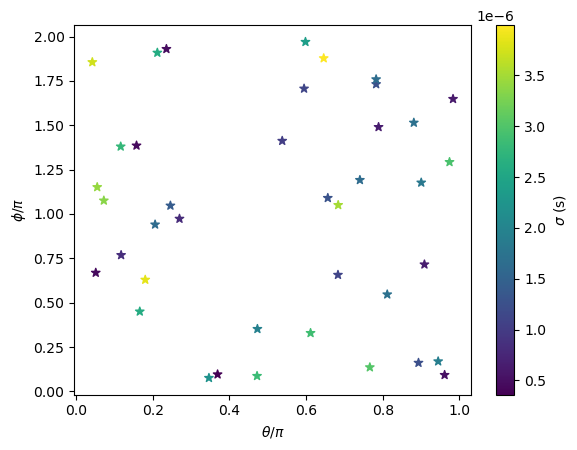

In [56]:
# Here's a plot of the pulsar locations
plt.xlabel(r'$\theta/\pi$')
plt.ylabel(r'$\phi/\pi$ ')
plt.scatter(thetas/np.pi, phis/np.pi, marker='*', s=40,
            c=sigmas, cmap='viridis')
plt.colorbar(label='$\sigma$ (s)')

And it's background sensitivity curve.

In [57]:
scGWB = hsen.GWBSensitivityCurve(list(spectra))

# Calculate background detection probability

Using the list of hasasia.sensitivity.Pulsar objects

Detection probability of the background in each realization:\, [0.65237889 0.65098234 0.63458887 0.68332907 0.66113333 0.64989401
 0.67909157 0.66139784 0.65040991 0.69139184 0.65496829 0.65077117
 0.62812484 0.67492431 0.6697304  0.6344071  0.63451222 0.63763278
 0.64818696 0.67255917 0.65701503 0.64819764 0.6857634  0.64928034
 0.66997195 0.64576931 0.6683764  0.68271362 0.65771871 0.63445169]


Text(0, 0.5, 'Number of Realizations')

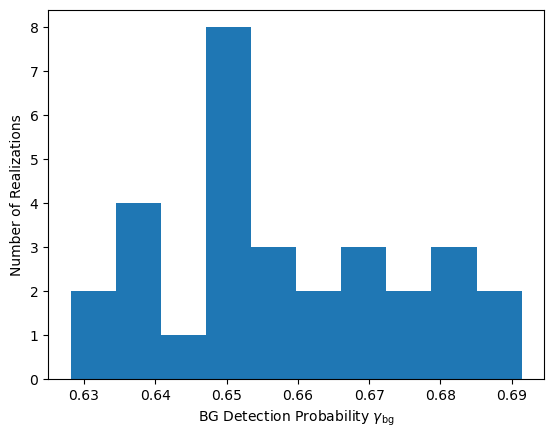

In [58]:
dp = det.detect_bg_pta(pulsars, spectra, cad, hc_bg)
print('Detection probability of the background in each realization:\,',dp)
plt.hist(dp)
plt.xlabel('BG Detection Probability $\gamma_\mathrm{bg}$')
plt.ylabel('Number of Realizations')

Using stored arrays, should be the same.

(array([2., 4., 1., 8., 3., 2., 3., 2., 3., 2.]),
 array([0.62812484, 0.63445154, 0.64077824, 0.64710494, 0.65343164,
        0.65975834, 0.66608504, 0.67241174, 0.67873844, 0.68506514,
        0.69139184]),
 <BarContainer object of 10 artists>)

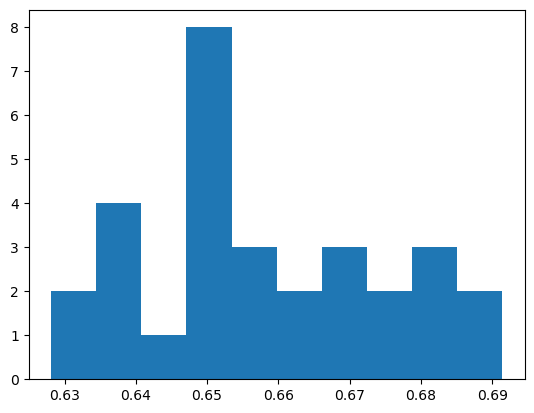

In [59]:
dp2 = det.detect_bg(thetas, phis, sigmas, fobs, cad, hc_bg)
plt.hist(dp2)

# Intermediate calculations 
These all follow equations from Rosado et al. 2015, and are calculated within the detect_bg and detect_bg_pta functions, returned if ret_all=True.

## Overlap reduction function 
$$ \Gamma_{ij} = \frac{3}{2} \gamma_{ij} \ln (\gamma_{ij}) - \frac{1}{4} \gamma_{ij} + \frac{1}{2} + \frac{1}{2}\delta_{ij} \quad\quad(24)$$
$$ \gamma_{ij} = [1-\cos (\theta_{ij})]/2$$

Can be calculated using the list of pulsars, 

In [60]:
Gamma = det._orf_pta(pulsars)

or directly for each pair of pulsars' angles. They should be the same.

In [61]:
Gamma2 = np.zeros((npsrs, npsrs))
for ii in range(npsrs):
    for jj in range(npsrs):
        if (jj>ii): # 0 otherwise, allows sum over all
            # calculate angle between two vectors.
            theta_ij =  det._relative_angle(pulsars[ii].theta, pulsars[ii].phi,
                                        pulsars[jj].theta, pulsars[jj].phi)
            # find ORF
            Gamma2[ii,jj] = det._orf_ij(ii, jj, theta_ij)

assert(np.all(Gamma==Gamma2)), 'Gamma calculation is failing!'

### Pulsar noise spectral density, $P_i$
$$ P_i = 2 \Delta t \sigma_i^2 \quad\quad(23)$$
Currently, this only accounts for white noise, but it allows for different sigma values for each pulsar. The sigma values are given by the mean of the toaerrs.

Text(0, 0.5, 'Number of pulsars')

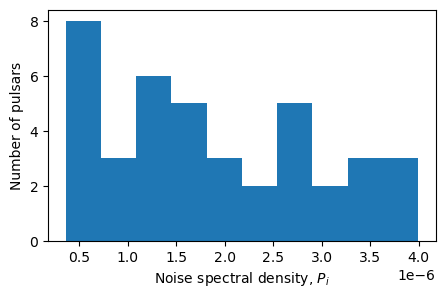

In [62]:
noise = det._white_noise(cad, sigmas)
plt.figure(figsize=(5,3))
plt.hist(sigmas)
plt.xlabel('Noise spectral density, $P_i$')
plt.ylabel('Number of pulsars')

## Power Spectral Density
$S_h$, the one-sided power spectral density of the GW signal in the timing residuals
$$ S_h = \frac{h_c^2}{12 \pi ^2 f_k^3} \quad \quad(25)$$
Let's demonstrate with the first realization.

In [63]:
Sh_bg = det._power_spectral_density(hc_bg, fobs)
print(Sh_bg.shape)

(25, 30)


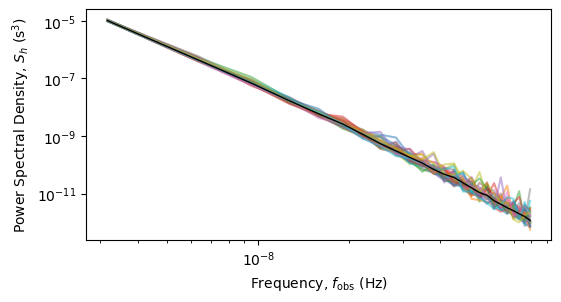

In [64]:
plt.figure(figsize=(6,3))
plt.xlabel('Frequency, $f_\mathrm{obs}$ (Hz)')
plt.ylabel('Power Spectral Density, $S_h$ (s$^3$)')
plt.loglog(fobs, Sh_bg, alpha=0.5)
plt.loglog(fobs, np.median(Sh_bg, axis=1), linewidth=1, color='k')

$S_{h0}$ is the **expected** one-sided power spectral density of the GW signal, given by Eq. (26), 
$$S_{h0} = \frac{\cal{A}\mathrm{yr}^{-4/3}}{12\pi^2} f^{-13/3}$$
 where $\cal{A}$ would be a fiducial characteristic strain amplitude such that $h_c=\cal{A}[f/\mathrm{yr}^{-1}]^{-2/3}$.
However, Rosado et al. (2019) find justify setting $S_{h0}=S_h$ so we use that approximation.

In [65]:
Sh0_bg = Sh_bg

## Probability Distribution Function
We calculate $\sigma_0$, $\sigma_1$, and $\mu_1$, which describe the mean-zero ($\mu_0=0$) PDF in the absence of a GWB, 
$$ p_0(S) = \frac{1}{\sqrt{2\pi\sigma_0^2} }e^{-\frac{(S-\mu_0)^2}{2\sigma_0^2}} $$
and the PDF in the presence of a GWB, 
 $$ p_1(S) = \frac{1}{\sqrt{2\pi\sigma_1^2} }e^{-\frac{(S-\mu_1)^2}{2\sigma_1^2}} $$
using
$$ \sigma_0^2 = 2\sum_f \sum_{ij} \frac{\Gamma_{ij}^2 S_{h0}^2 P_i P_j  }{\big[ [P_i + S_{h0}] [P_j +S_{h0}] + \Gamma_{ij}^2 S_{h0}^2  \big]^2  } \quad\quad (A17)$$
$$\mu_1 = 1\sum_f \sum_{ij} \frac{\Gamma_{ij}^2 S_h S_{h0}}{[P_i + S_{h0}] [P_j + S_{h0}] + \Gamma_{ij}^2 S_{h0}^2} \quad\quad (A16) $$

$$ \sigma_1^2 = 2 \sum_f \sum_{ij} \frac{\Gamma_{ij}^2 S_{h0}^2 \big[ [P_i + S_h] [P_j + S_h] + \Gamma_{ij}^2 S_h^2   \big]  }{\big[[P_i + S_{h0}][P_j + S_{h0}] + \Gamma_{ij}^2 S_{h0}^2  \big]^2  } \quad\quad (A18)$$


In [66]:
mu_1B = det._mean1_Bstatistic(noise, Gamma, Sh_bg, Sh0_bg)

sigma_0B = det._sigma0_Bstatistic(noise, Gamma, Sh0_bg)

sigma_1B = det._sigma1_Bstatistic(noise, Gamma, Sh_bg, Sh0_bg)


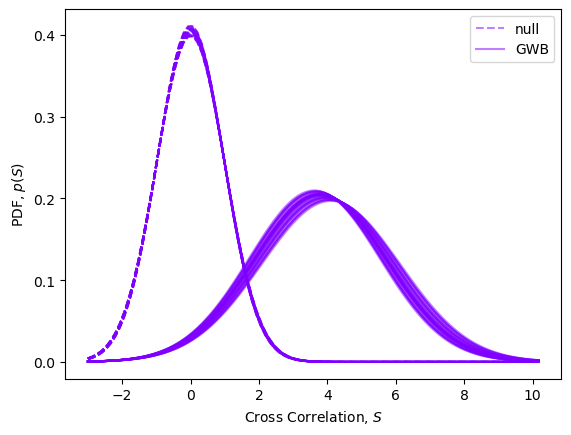

In [67]:
nreals = len(sigma_0B)
xarr = np.linspace(-3*np.max(sigma_0B),np.max(mu_1B)+3*np.max(sigma_1B),100)
pdf0 = np.zeros((len(xarr), nreals))
pdf1 = np.zeros((len(xarr), nreals))


colors= cm.rainbow(-np.linspace(0,1,nreals))
plt.xlabel('Cross Correlation, $S$')
plt.ylabel('PDF, $p(S)$')
for rr in range(nreals):
    pdf0[:,rr] = sp.stats.norm.pdf(xarr, 0, sigma_0B[rr])
    pdf1[:,rr] = sp.stats.norm.pdf(xarr, mu_1B[rr], sigma_1B[rr])
    if(rr==0):
        label0='null'
        label1='GWB'
    else:
        label0=None
        label1=None
    plt.plot(xarr, pdf0[:,rr], label=label0, linestyle='dashed', 
             color=colors[rr], alpha=0.5)
    plt.plot(xarr, pdf1[:,rr], label=label1, linestyle='solid',
             color=colors[rr], alpha=0.5)
plt.legend()


## Detection Probability
We now have all the parameters necessary to calculate the background detection probability, $\gamma_\mathrm{bg}$, using

$$ \gamma_{bg} = \frac{1}{2} \mathrm{erfc} \big[ \frac{\sqrt{2} \sigma_0 \mathrm{erfc}^{-1}(2\alpha_0) - \mu_1}{\sqrt{2} \sigma_1}\big] \quad\quad(15)$$

(array([2., 4., 1., 8., 3., 2., 3., 2., 3., 2.]),
 array([0.62812484, 0.63445154, 0.64077824, 0.64710494, 0.65343164,
        0.65975834, 0.66608504, 0.67241174, 0.67873844, 0.68506514,
        0.69139184]),
 <BarContainer object of 10 artists>)

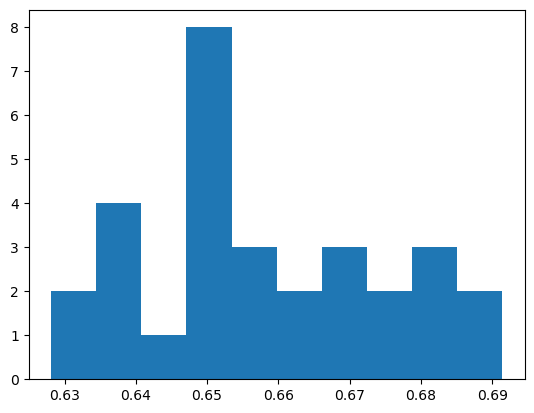

In [68]:
gamma_bg = det._bg_detection_probability(sigma_0B, sigma_1B, mu_1B)
plt.hist(gamma_bg)

# Check SNR consistency
### $\mathrm{S/N_B}(\Gamma, S_h, P)$ Comparison
There is a function that calculates the B-statistic GWB signal-to-noise ratio, $\mathrm{S/N}_B\equiv \frac{\mu_1}{\sigma_1}$ using $P_i$, $S_h$, and $\Gamma_{ij}$. 
$$S/N_B \equiv \frac{\mu_1}{ \sigma_1} = \Bigg[ 2 \sum_f \sum_{ij} \frac{\Gamma_{ij}^2 S_h^2}{P_iP_j + S_h[P_i + P_j] + S_h^2[1+\Gamma_{ij}^2]}   \Bigg]^{1/2} \quad\quad\quad(\mathrm{A}19)$$
We can use this to check that our intermediate variables are all consistent.

(30,) 1.90e+00, 1.91e+00, 1.92e+00, 1.95e+00, 2.00e+00, 2.01e+00, 2.03e+00
(30,) 1.90e+00, 1.91e+00, 1.92e+00, 1.95e+00, 2.00e+00, 2.01e+00, 2.03e+00


Text(0, 0.5, '$\\mathrm{S/N_B} = \\mu_1/\\sigma_1$')

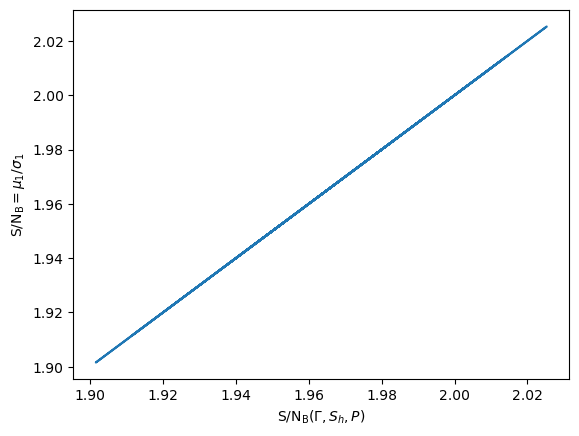

In [69]:
SNR_B = det.SNR_bg_B(noise, Gamma, Sh_bg)
SNR_1 = mu_1B/sigma_1B
print(SNR_B.shape, holo.utils.stats(SNR_B))
print(SNR_1.shape, holo.utils.stats(SNR_1))
plt.plot(SNR_B, SNR_1) # should be equal
plt.xlabel('$\mathrm{S/N_B}(\Gamma, S_h, P)$')
plt.ylabel('$\mathrm{S/N_B} = \mu_1/\sigma_1$')

### hasasia.sensitivity.GWBSensitivityCurve.SNR(Sh) comparison
Hasasia.sensitivity.SNR(Sh) uses $$S_h = \frac{3H_0^2}{2\pi^2} \frac{\Omega_\mathrm{gw}(f)}{f^3}$$ in units of strain^2/Hz, where $\Omega_{gw}=\frac{2\pi^2}{3\;H_0^2}f^3\;S_I$ 
This uses a generic power law GWB calculated by hasasia in the $\Omega_{gw}$ calculation. 

Or we can calculate S_h for our GWBs, based on Hazboun et al. 2019 Eq. (56) $$h_c(f) \equiv \sqrt{f S_h(f)}$$
rewriting this as
$$S_h(f) = h_c(f)^2/f$$

In [70]:
Sh_heff = det._Sh_hasasia_noise_bg(scGWB)
Sh_hmod = det._Sh_hasasia_modeled_bg(fobs, hc_bg)
print('Sh_heff at each frequency\n', Sh_heff)
print('Sh_hmod at each frequency, averaged over realizations\n', np.mean(Sh_hmod, axis=1))

Sh_heff at each frequency
 [1.24088851e-20 1.38634366e-20 2.90575529e-20 5.07275542e-20
 7.88573151e-20 1.13782359e-19 1.56676806e-19 2.13058499e-19
 3.50885040e-19 1.38033237e+11 5.25263729e-19 4.78559891e-19
 5.38070535e-19 6.14889866e-19 7.01047937e-19 7.94651519e-19
 8.95049956e-19 1.00196915e-18 1.11527883e-18 2.50668217e-18
 1.36084091e-18 1.49304900e-18 1.63153962e-18 1.77632693e-18
 1.92743808e-18]
Sh_hmod at each frequency, averaged over realizations
 [1.23056025e-20 2.15162738e-21 7.57804227e-22 3.23651562e-22
 1.75044124e-22 1.18437110e-22 6.98005834e-23 4.72786790e-23
 3.41278831e-23 2.25120780e-23 1.85622972e-23 1.43154652e-23
 1.03892518e-23 1.01638767e-23 7.19119001e-24 5.20150711e-24
 4.57250832e-24 4.17870342e-24 2.87280516e-24 2.77329999e-24
 2.23112120e-24 1.62573233e-24 1.64210740e-24 1.38994671e-24
 1.51340541e-24]


Text(0, 0.5, 'Power Spectral Density $S_h$ (Hz)$^{-1}$')

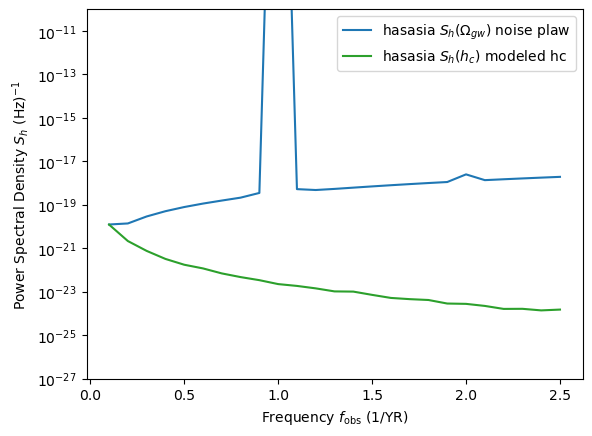

In [71]:
plt.plot(fobs*YR, Sh_heff, label='hasasia $S_h(\Omega_{gw})$ noise plaw', color="tab:blue")
plt.plot(fobs*YR, np.mean(Sh_hmod, axis=1), label='hasasia $S_h(h_c)$ modeled hc', color='tab:green')
plt.yscale('log')
plt.ylim(10e-28, 10e-11)
plt.legend()
plt.xlabel('Frequency $f_\mathrm{obs}$ (1/YR)')
plt.ylabel('Power Spectral Density $S_h$ (Hz)$^{-1}$')

These look reasonably close for most frequencies, but the generic calculation has one very high value in th 10th frequency bin. Maybe this isn't actually the background calculation, but a sensitivity to the background calculation (and we have very low sensitivity at that one place).

In [72]:
SNR_hgen = det.SNR_hasasia_noise_bg(scGWB)
SNR_hmod = det.SNR_hasasia_modeled_bg(scGWB, hc_bg)

print('SNR_B of each realization\n', SNR_B)
print('SNR_hmod of each realization\n', SNR_hmod) 
print('SNR_hgen\n', SNR_hgen) # why is this the exact same as when I calculated it with a different scGWB?


SNR_B of each realization
 [1.9514464  1.95226769 1.92090266 2.01301431 1.9621067  1.94926511
 2.00383629 1.97557674 1.94428626 2.02528748 1.95234099 1.94282189
 1.90157848 1.99169806 1.98672556 1.91146048 1.91390974 1.91969335
 1.94043312 1.98944628 1.95726574 1.93762139 2.01477094 1.94064294
 1.9833421  1.93483694 1.97695077 2.01090319 1.96210255 1.91238052]
SNR_hmod of each realization
 [1.01041919 1.01521092 0.98407971 1.07321649 1.01522197 1.01120799
 1.06309108 1.04169152 1.00012995 1.08238333 1.00738892 0.99657582
 0.95839961 1.04716885 1.04711576 0.96588542 0.97048131 0.97591302
 0.99673937 1.04690042 1.0130313  0.9913147  1.07210698 0.99518729
 1.04001667 0.99015227 1.03073245 1.07014009 1.02113845 0.96762808]
SNR_hgen
 6.928203230275509


Text(0, 0.5, 'SNR($S_h$)')

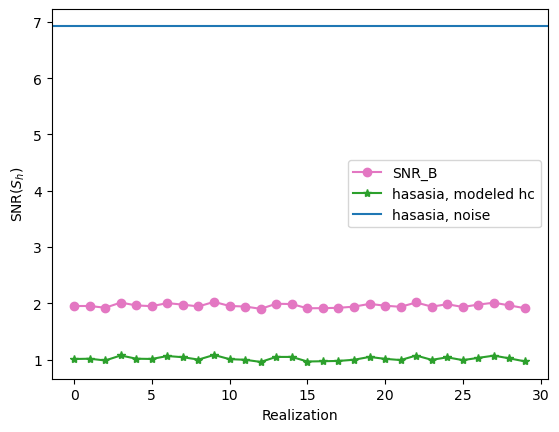

In [73]:
reals = np.arange(len(SNR_B))
plt.plot(reals, SNR_B, marker='o', label='SNR_B', color='tab:pink')
plt.plot(reals, SNR_hmod, marker='*', label='hasasia, modeled hc', color='tab:green')
plt.axhline(SNR_hgen, label='hasasia, noise', color='tab:blue')
plt.legend()
plt.xlabel('Realization')
plt.ylabel('SNR($S_h$)')
# plt.yscale('log')

Text(0, 0.5, 'SNR($S_h$)')

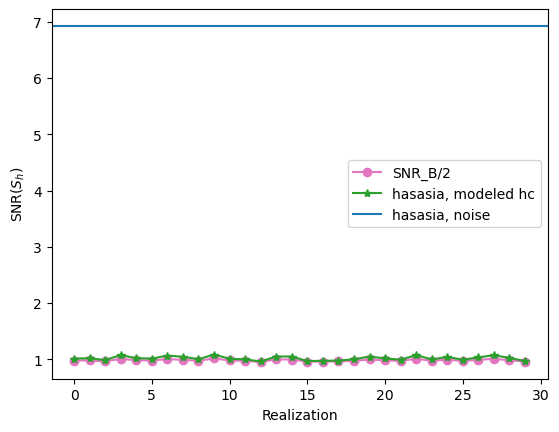

In [74]:
reals = np.arange(len(SNR_B))
plt.plot(reals, SNR_B/2, marker='o', label='SNR_B/2', color='tab:pink')
plt.plot(reals, SNR_hmod, marker='*', label='hasasia, modeled hc', color='tab:green')
plt.axhline(SNR_hgen, label='hasasia, noise', color='tab:blue')
plt.legend()
plt.xlabel('Realization')
plt.ylabel('SNR($S_h$)')
# plt.yscale('log')

Text(0, 0.5, 'Ratio SNR_B/SNR_hasasia')

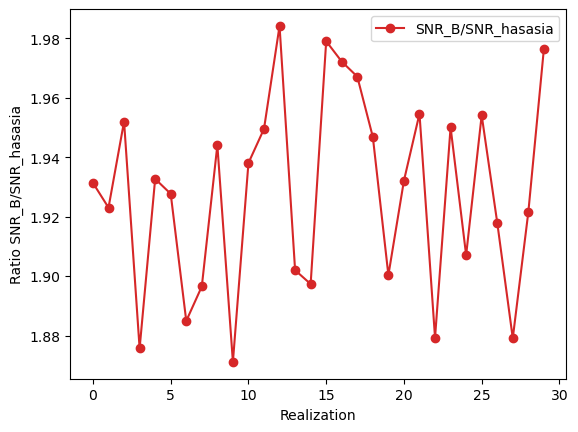

In [75]:
reals = np.arange(len(SNR_B))
plt.plot(reals, SNR_B/SNR_hmod, marker='o', label='SNR_B/SNR_hasasia', color='tab:red')
# plt.plot(reals, SNR_hmod, marker='*', label='hasasia, modeled hc', color='tab:green')
# plt.axhline(SNR_hgen, label='hasasia, gen plaw hc', color='tab:blue')
plt.legend()
plt.xlabel('Realization')
plt.ylabel('Ratio SNR_B/SNR_hasasia')
# plt.yscale('log')

The hasasia SNR with a generic background and modeled background look similar. Using a modeled GWB gives slightly higher SNR's than the generic GWB. These both give ~2-3x higher SNRs than our calculation using the Rosado+2015 equations, but are of the same order of magnitude.

In [76]:
print('Sh_bg averaged over realizations\n', np.mean(Sh_bg,axis=1))

Sh_bg averaged over realizations
 [1.03473663e-05 4.52307733e-07 7.08013366e-08 1.70092305e-08
 5.88754813e-09 2.76638258e-09 1.19781546e-09 6.21172617e-10
 3.54283784e-10 1.89296475e-10 1.28995124e-10 8.35930011e-11
 5.16921400e-11 4.36043945e-11 2.68747968e-11 1.70850468e-11
 1.33040419e-11 1.08448483e-11 6.69153745e-12 5.82993619e-12
 4.25413743e-12 2.82442874e-12 2.61019425e-12 2.02909607e-12
 2.03611455e-12]
